## Import the libraries we'll use

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#plots
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

#tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras import metrics
from keras import utils

!pip install visualkeras
import visualkeras
from tensorflow.keras.utils import plot_model

%matplotlib inline

#Import CIFAR-10, CIFAR-100 Classification
from keras.datasets import cifar10, cifar100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 60.2 MB/s eta 0:00:00


## Check Runtime Resources





In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 15 17:35:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    41W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Import CIFAR-10 Data

In [4]:
# load training and testing datasets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # or cifar100.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [5]:
# Pixel values range from 0 to 255. To normalize the data, just divide all values by 255.
x_train = x_train / 255
x_test = x_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
y_train = y_train.flatten()
y_test = y_test.flatten()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(x_train.shape[0])
shuffled_indices = np.random.permutation(indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Experiment with VGG16 pre-trained models

In [6]:
# import pre-trained model
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

vgg16_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

### VGG16 Model Run 1
1. Augment Data
2. Optimize with SGD @ learning rate of 0.001
3. No additional dense layers to learn


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
  
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = vgg16_model(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [8]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 19s 10ms/step - loss: 1.5026 - accuracy: 0.4630 - val_loss: 1.2608 - val_accuracy: 0.5758
Epoch 2/20
704/704 [==============================] - 6s 9ms/step - loss: 1.0936 - accuracy: 0.6164 - val_loss: 1.1481 - val_accuracy: 0.6102
Epoch 3/20
704/704 [==============================] - 6s 9ms/step - loss: 0.9713 - accuracy: 0.6575 - val_loss: 1.4380 - val_accuracy: 0.5266
Epoch 4/20
704/704 [==============================] - 6s 9ms/step - loss: 0.8980 - accuracy: 0.6851 - val_loss: 0.8379 - val_accuracy: 0.7082
Epoch 5/20
704/704 [==============================] - 6s 9ms/step - loss: 0.8406 - accuracy: 0.7067 - val_loss: 0.9644 - val_accuracy: 0.6690
Epoch 6/20
704/704 [==============================] - 6s 9ms/step - loss: 0.7982 - accuracy: 0.7196 - val_loss: 1.2193 - val_accuracy: 0.5944
Epoch 7/20
704/704 [==============================] - 6s 9ms/step - loss: 0.7669 - accuracy: 0.7327 - val_loss: 0.6823 - val_accuracy: 0.7564
Epoc

,loss,accuracy,val_loss,val_accuracy
0,1.502616,0.463022,1.260802,0.5758
1,1.093578,0.616378,1.148147,0.6102
2,0.971309,0.657467,1.438025,0.5266
3,0.897967,0.685067,0.837896,0.7082
4,0.840645,0.706667,0.964440,0.6690
5,0.798214,0.719600,1.219319,0.5944
6,0.766919,0.732667,0.682340,0.7564
7,0.740716,0.740689,0.691883,0.7636
8,0.716973,0.750578,0.759680,0.7368
9,0.696791,0.755822,1.082681,0.6596


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________
None


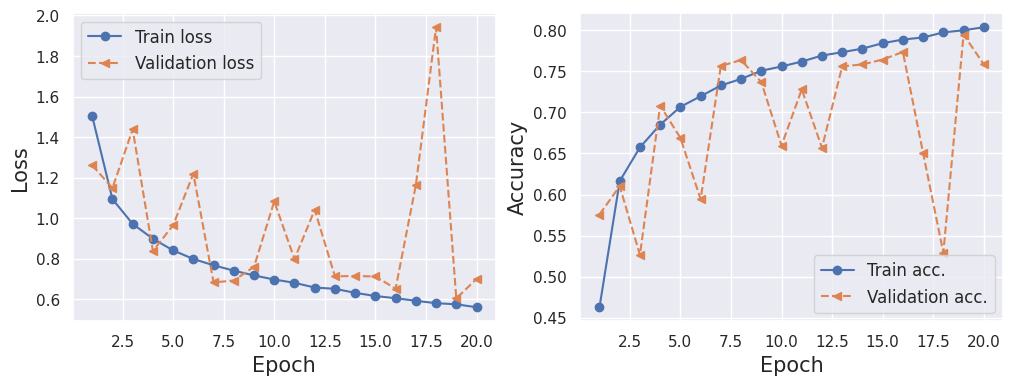

In [9]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [10]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.7269 - accuracy: 0.7513

Test Acc. 75.13%


### VGG16 Model Run 2
1. Experiment with multiple dense layers with dropouts [512, 256, 128] w/ Dropout=0.4

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
  
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = vgg16_model(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [12]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 10s 10ms/step - loss: 1.8778 - accuracy: 0.3241 - val_loss: 1.0003 - val_accuracy: 0.6896
Epoch 2/20
704/704 [==============================] - 7s 10ms/step - loss: 1.2721 - accuracy: 0.5635 - val_loss: 1.0219 - val_accuracy: 0.6652
Epoch 3/20
704/704 [==============================] - 7s 10ms/step - loss: 1.0663 - accuracy: 0.6470 - val_loss: 0.9993 - val_accuracy: 0.6808
Epoch 4/20
704/704 [==============================] - 7s 10ms/step - loss: 0.9720 - accuracy: 0.6853 - val_loss: 0.9467 - val_accuracy: 0.7020
Epoch 5/20
704/704 [==============================] - 7s 10ms/step - loss: 0.9020 - accuracy: 0.7096 - val_loss: 0.7018 - val_accuracy: 0.7736
Epoch 6/20
704/704 [==============================] - 7s 10ms/step - loss: 0.8628 - accuracy: 0.7257 - val_loss: 0.8554 - val_accuracy: 0.7274
Epoch 7/20
704/704 [==============================] - 7s 10ms/step - loss: 0.8307 - accuracy: 0.7364 - val_loss: 0.6918 - val_accuracy: 0.778

,loss,accuracy,val_loss,val_accuracy
0,1.877815,0.324089,1.000320,0.6896
1,1.272100,0.563511,1.021877,0.6652
2,1.066344,0.646978,0.999296,0.6808
3,0.971987,0.685333,0.946652,0.7020
4,0.902038,0.709578,0.701762,0.7736
5,0.862820,0.725689,0.855354,0.7274
6,0.830689,0.736444,0.691808,0.7782
7,0.794556,0.750178,0.753450,0.7574
8,0.776913,0.756222,0.611684,0.7954
9,0.753839,0.764311,0.764999,0.7628


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               1313

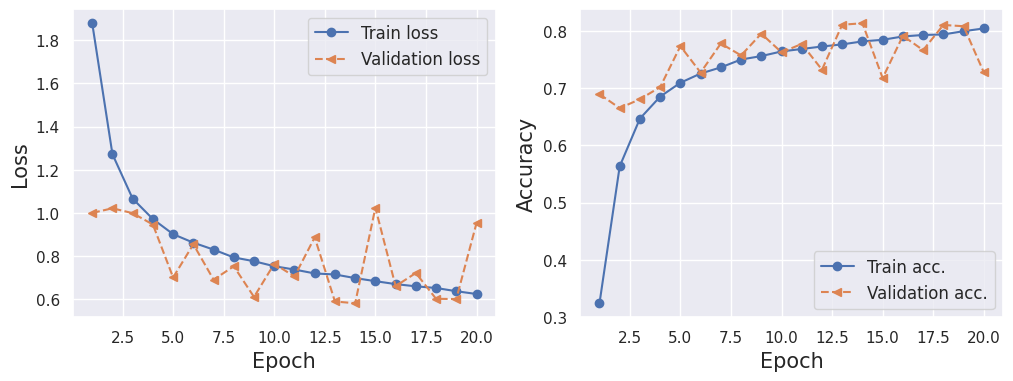

In [13]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [14]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.9296 - accuracy: 0.7290

Test Acc. 72.90%


### VGG16 Model Run 3
- shrink size and number of dense layers
- eliminate dropout layers
- freeze all layers except fourth from last

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = vgg16_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

for layer in model.layers[:-4]:
    layer.trainable = False

opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [16]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 4s 5ms/step - loss: 0.9792 - accuracy: 0.7216 - val_loss: 0.6581 - val_accuracy: 0.7978
Epoch 2/20
704/704 [==============================] - 3s 5ms/step - loss: 0.5299 - accuracy: 0.8391 - val_loss: 0.5672 - val_accuracy: 0.8110
Epoch 3/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4720 - accuracy: 0.8468 - val_loss: 0.5429 - val_accuracy: 0.8160
Epoch 4/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4504 - accuracy: 0.8505 - val_loss: 0.5328 - val_accuracy: 0.8166
Epoch 5/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4389 - accuracy: 0.8528 - val_loss: 0.5288 - val_accuracy: 0.8184
Epoch 6/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4322 - accuracy: 0.8540 - val_loss: 0.5241 - val_accuracy: 0.8196
Epoch 7/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4273 - accuracy: 0.8554 - val_loss: 0.5223 - val_accuracy: 0.8190
Epoch 

,loss,accuracy,val_loss,val_accuracy
0,0.979173,0.721600,0.658084,0.7978
1,0.529912,0.839111,0.567243,0.8110
2,0.471983,0.846844,0.542906,0.8160
3,0.450401,0.850511,0.532794,0.8166
4,0.438909,0.852822,0.528812,0.8184
5,0.432225,0.853956,0.524100,0.8196
6,0.427327,0.855422,0.522294,0.8190
7,0.423716,0.856289,0.520958,0.8196
8,0.420968,0.857267,0.518404,0.8200
9,0.418647,0.857333,0.517094,0.8204


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,784,810
Trainable params: 70,122
Non-train

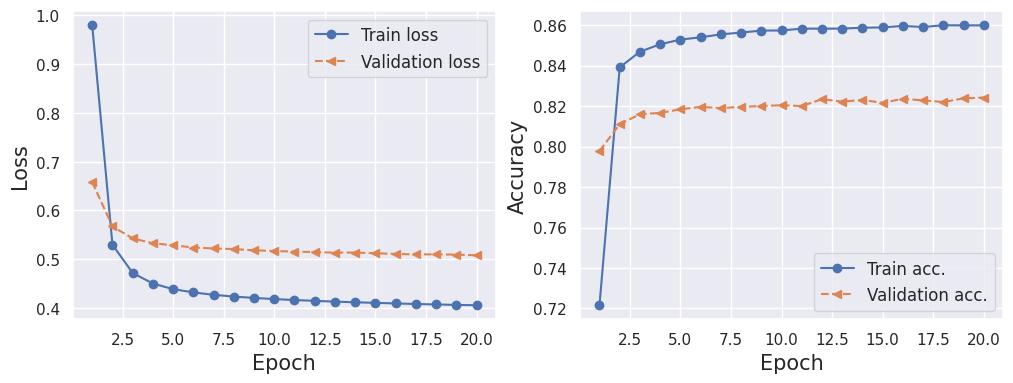

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [18]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.5108 - accuracy: 0.8293

Test Acc. 82.93%


### VGG16 Model Run 4
Replicate original notebook implementation

[Custom VGG16 + CNN Medium Reference](https://906-22912.medium.com/transfer-learning-a-vgg16-based-custom-cnn-for-cifar-10-image-classification-bb3a0da486d1)

In [103]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.2),
#     ]
# )

inputs = keras.Input(shape=(32, 32, 3))
#x = data_augmentation(inputs)
x = vgg16_model(inputs)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# for layer in model.layers[:-4]:
#    layer.trainable = False

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [104]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 5s 6ms/step - loss: 0.5700 - accuracy: 0.8122 - val_loss: 0.5304 - val_accuracy: 0.8238
Epoch 2/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4545 - accuracy: 0.8478 - val_loss: 0.5261 - val_accuracy: 0.8236
Epoch 3/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4414 - accuracy: 0.8505 - val_loss: 0.5231 - val_accuracy: 0.8236
Epoch 4/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4329 - accuracy: 0.8521 - val_loss: 0.5147 - val_accuracy: 0.8276
Epoch 5/20
704/704 [==============================] - 4s 6ms/step - loss: 0.4277 - accuracy: 0.8556 - val_loss: 0.5090 - val_accuracy: 0.8294
Epoch 6/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4222 - accuracy: 0.8572 - val_loss: 0.5082 - val_accuracy: 0.8308
Epoch 7/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4192 - accuracy: 0.8574 - val_loss: 0.5066 - val_accuracy: 0.8298
Epoch 

,loss,accuracy,val_loss,val_accuracy
0,0.570025,0.812222,0.530384,0.8238
1,0.454487,0.847822,0.526127,0.8236
2,0.441430,0.850533,0.523063,0.8236
3,0.432894,0.852111,0.514710,0.8276
4,0.427679,0.855622,0.508981,0.8294
5,0.422164,0.857200,0.508228,0.8308
6,0.419218,0.857356,0.506556,0.8298
7,0.417702,0.857911,0.510459,0.8290
8,0.412630,0.858156,0.500764,0.8308
9,0.410170,0.860400,0.501109,0.8302


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_23 (Flatten)        (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_34 (Dropout)        (None, 1024)              0         
                                                                 
 dense_65 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_35 (Dropout)        (None, 1024)              0  

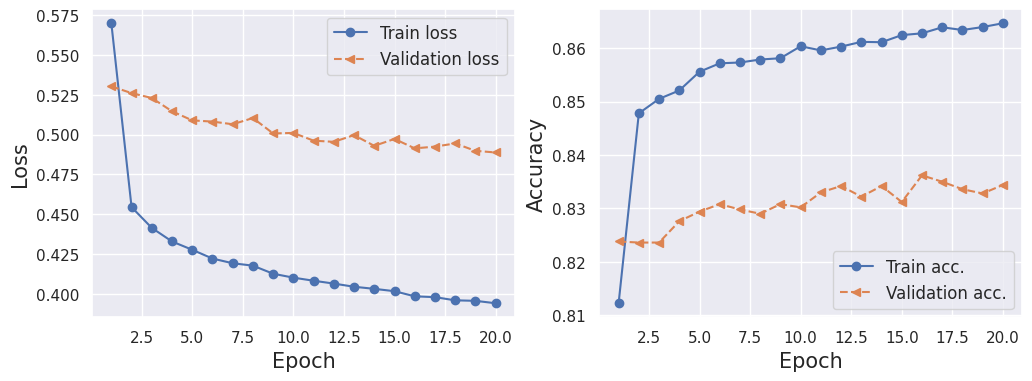

In [105]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [106]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.4898 - accuracy: 0.8307

Test Acc. 83.07%


In [107]:
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(x_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 3ms/step
[3 8 8 ... 5 1 7]


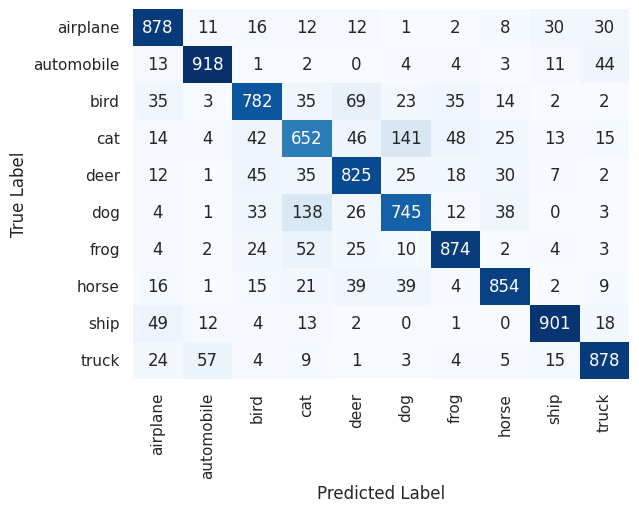

In [108]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [137]:
# Define the animal and non-animal classes
animal_indices = [2, 3, 4, 5, 6, 7]  # Indices of animal classes in the confusion matrix
non_animal_indices = [0, 1, 8, 9]  # Indices of non-animal classes in the confusion matrix

# Extract animal and non-animal confusion matrices
animal_confusion_matrix = tf.gather(confusion_matrix, indices=animal_indices, axis=0)
animal_confusion_matrix = tf.gather(animal_confusion_matrix, indices=animal_indices, axis=1)

non_animal_confusion_matrix = tf.gather(confusion_matrix, indices=non_animal_indices, axis=0)
non_animal_confusion_matrix = tf.gather(non_animal_confusion_matrix, indices=non_animal_indices, axis=1)

# Convert the confusion matrices to NumPy arrays
animal_confusion_matrix_np = animal_confusion_matrix.numpy()
non_animal_confusion_matrix_np = non_animal_confusion_matrix.numpy()

# Calculate true positives and false positives for animal and non-animal classes
animal_true_positives = np.diag(animal_confusion_matrix_np)
animal_false_positives = np.sum(animal_confusion_matrix_np, axis=0) - animal_true_positives

non_animal_true_positives = np.diag(non_animal_confusion_matrix_np)
non_animal_false_positives = np.sum(non_animal_confusion_matrix_np, axis=0) - non_animal_true_positives

# Calculate precision for animal and non-animal classes
animal_precision = np.sum(animal_true_positives) / (np.sum(animal_true_positives) + np.sum(animal_false_positives))
non_animal_precision = np.sum(non_animal_true_positives) / (np.sum(non_animal_true_positives) + np.sum(non_animal_false_positives))

print("Animal Precision:", animal_precision)
print("Non-Animal Precision:", non_animal_precision)

Animal Precision (Sum of all classes): 0.8101352508132169
Non-Animal Precision: 0.9192594497300077


## Experiment with ResNet50 Pre-Trained Models

In [68]:
# import pre-trained model
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50_model = ResNet50(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(224,224,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### ResNet 50 Model 1

In [69]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.UpSampling2D(size=(7,7))(inputs)
x = resnet50_model(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

#RMSprop accuracy >2x vs Adam or SGD
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [70]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 96s 97ms/step - loss: 1.8639 - accuracy: 0.5050 - val_loss: 3.6324 - val_accuracy: 0.1278
Epoch 2/20
704/704 [==============================] - 67s 96ms/step - loss: 0.8962 - accuracy: 0.6976 - val_loss: 7.4128 - val_accuracy: 0.4318
Epoch 3/20
704/704 [==============================] - 67s 96ms/step - loss: 0.7111 - accuracy: 0.7606 - val_loss: 1.0823 - val_accuracy: 0.6574
Epoch 4/20
704/704 [==============================] - 67s 96ms/step - loss: 0.5827 - accuracy: 0.8022 - val_loss: 1.8471 - val_accuracy: 0.6348
Epoch 5/20
704/704 [==============================] - 67s 96ms/step - loss: 0.4911 - accuracy: 0.8384 - val_loss: 2.4779 - val_accuracy: 0.4442
Epoch 6/20
704/704 [==============================] - 67s 96ms/step - loss: 0.3975 - accuracy: 0.8659 - val_loss: 1.0841 - val_accuracy: 0.6866
Epoch 7/20
704/704 [==============================] - 67s 95ms/step - loss: 0.3226 - accuracy: 0.8960 - val_loss: 1.0041 - val_accuracy:

,loss,accuracy,val_loss,val_accuracy
0,1.863896,0.505044,3.632432,0.1278
1,0.896240,0.697600,7.412818,0.4318
2,0.711059,0.760644,1.082301,0.6574
3,0.582679,0.802222,1.847051,0.6348
4,0.491078,0.838356,2.477910,0.4442
5,0.397528,0.865889,1.084064,0.6866
6,0.322616,0.895978,1.004140,0.7142
7,0.247521,0.920244,0.897054,0.7672
8,0.186952,0.938622,0.987547,0.7860
9,0.151598,0.949244,1.087209,0.7654


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_5 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 100352)            0         
                                                                 
 dense_30 (Dense)            (None, 10)                1003530   
                                                                 
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________

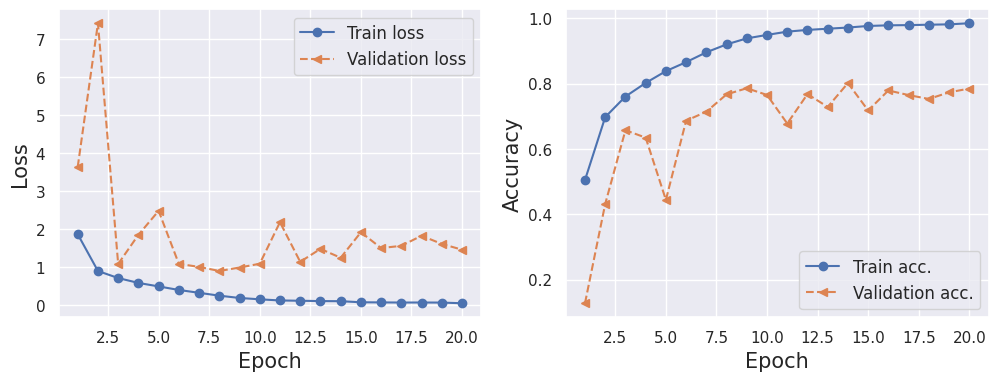

In [71]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [72]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 4s 14ms/step - loss: 1.4278 - accuracy: 0.7895

Test Acc. 78.95%


### ResNet50 Model 2
1. Add BatchNormalization
2. Add Dense Layers w/ dropouts

[ResNet50 Kaggle Tutorial](https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner)

In [76]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.UpSampling2D(size=(7,7))(inputs)
x = resnet50_model(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.SGD(learning_rate=0.001) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [77]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 86s 100ms/step - loss: 1.6894 - accuracy: 0.5178 - val_loss: 1.1149 - val_accuracy: 0.7262
Epoch 2/20
704/704 [==============================] - 69s 98ms/step - loss: 0.8529 - accuracy: 0.7745 - val_loss: 0.7346 - val_accuracy: 0.7850
Epoch 3/20
704/704 [==============================] - 69s 99ms/step - loss: 0.5787 - accuracy: 0.8371 - val_loss: 0.6142 - val_accuracy: 0.8042
Epoch 4/20
704/704 [==============================] - 69s 98ms/step - loss: 0.4527 - accuracy: 0.8690 - val_loss: 0.5637 - val_accuracy: 0.8134
Epoch 5/20
704/704 [==============================] - 69s 98ms/step - loss: 0.3751 - accuracy: 0.8921 - val_loss: 0.5344 - val_accuracy: 0.8208
Epoch 6/20
704/704 [==============================] - 69s 98ms/step - loss: 0.3207 - accuracy: 0.9074 - val_loss: 0.5153 - val_accuracy: 0.8274
Epoch 7/20
704/704 [==============================] - 69s 98ms/step - loss: 0.2806 - accuracy: 0.9208 - val_loss: 0.5047 - val_accuracy

,loss,accuracy,val_loss,val_accuracy
0,1.689403,0.517844,1.114945,0.7262
1,0.852908,0.774467,0.734570,0.7850
2,0.578678,0.837111,0.614174,0.8042
3,0.452664,0.869044,0.563655,0.8134
4,0.375130,0.892089,0.534366,0.8208
5,0.320683,0.907378,0.515340,0.8274
6,0.280600,0.920844,0.504740,0.8318
7,0.250735,0.928444,0.498343,0.8340
8,0.222037,0.937756,0.494378,0.8382
9,0.201738,0.944156,0.494161,0.8386


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_7 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_13 (Flatten)        (None, 100352)            0         
                                                                 
 dense_34 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                          

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [78]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 4s 14ms/step - loss: 0.5317 - accuracy: 0.8362

Test Acc. 83.62%


### ResNet50 Model 3

[GitHub Reference](https://github.com/frlim/data2040_final/blob/master/project_2/CNN_Final.ipynb)

In [79]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.UpSampling2D(size=(7,7))(inputs)
x = resnet50_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

opt = tf.keras.optimizers.SGD(learning_rate=0.001) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [80]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 89s 102ms/step - loss: 1.0356 - accuracy: 0.6515 - val_loss: 0.7401 - val_accuracy: 0.7564
Epoch 2/20
704/704 [==============================] - 71s 101ms/step - loss: 0.4602 - accuracy: 0.8452 - val_loss: 0.6749 - val_accuracy: 0.7818
Epoch 3/20
704/704 [==============================] - 71s 101ms/step - loss: 0.3184 - accuracy: 0.8988 - val_loss: 0.6368 - val_accuracy: 0.7916
Epoch 4/20
704/704 [==============================] - 71s 101ms/step - loss: 0.2368 - accuracy: 0.9263 - val_loss: 0.6234 - val_accuracy: 0.8012
Epoch 5/20
704/704 [==============================] - 71s 100ms/step - loss: 0.1866 - accuracy: 0.9454 - val_loss: 0.6159 - val_accuracy: 0.8024
Epoch 6/20
704/704 [==============================] - 70s 100ms/step - loss: 0.1540 - accuracy: 0.9578 - val_loss: 0.6157 - val_accuracy: 0.8030
Epoch 7/20
704/704 [==============================] - 71s 101ms/step - loss: 0.1291 - accuracy: 0.9661 - val_loss: 0.6192 - val_ac

,loss,accuracy,val_loss,val_accuracy
0,1.035627,0.651467,0.740093,0.7564
1,0.460201,0.845156,0.674851,0.7818
2,0.318353,0.898844,0.636839,0.7916
3,0.236807,0.926289,0.623436,0.8012
4,0.186631,0.945444,0.615919,0.8024
5,0.153974,0.957800,0.615728,0.8030
6,0.129070,0.966111,0.619231,0.8076
7,0.108535,0.972622,0.617729,0.8114
8,0.093562,0.977044,0.616176,0.8098
9,0.083892,0.980444,0.615991,0.8130


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_14 (Flatten)        (None, 100352)            0         
                                                                 
 batch_normalization_8 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_37 (Dense)            (None, 1024)              102

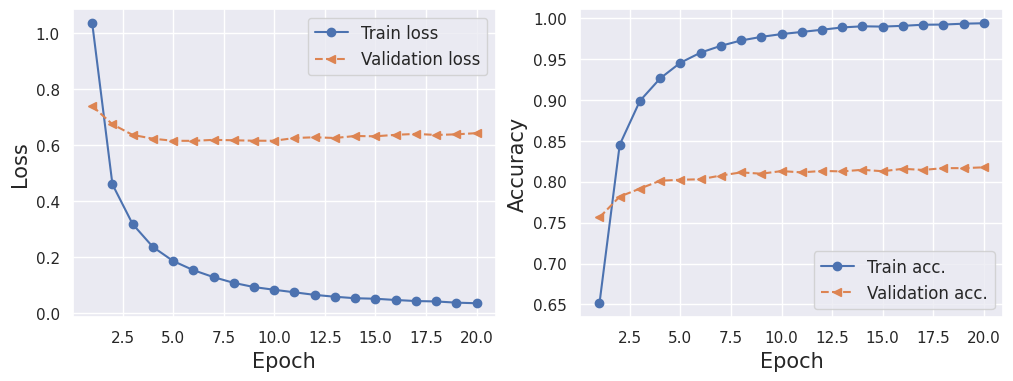

In [81]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [82]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 5s 14ms/step - loss: 0.6401 - accuracy: 0.8181

Test Acc. 81.81%


### ResNet50 Model 4

Attempt to replicate results from original model + data augmentation

In [138]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = layers.UpSampling2D(size=(7,7))(inputs)
x = data_augmentation(x)
x = resnet50_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

#opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='Adam',
              metrics=["accuracy"])

In [139]:
# run the model and display output
history = model.fit(
    x = x_train, 
    y = y_train,
    epochs=20, 
    batch_size=64,
    validation_split=0.1,
    verbose=1)

#show output of model
display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
704/704 [==============================] - 112s 104ms/step - loss: 0.3005 - accuracy: 0.9028 - val_loss: 0.4725 - val_accuracy: 0.8540
Epoch 2/20
704/704 [==============================] - 72s 102ms/step - loss: 0.2227 - accuracy: 0.9250 - val_loss: 0.4034 - val_accuracy: 0.8716
Epoch 3/20
704/704 [==============================] - 72s 102ms/step - loss: 0.2087 - accuracy: 0.9311 - val_loss: 0.8142 - val_accuracy: 0.7888
Epoch 4/20
704/704 [==============================] - 72s 102ms/step - loss: 0.1940 - accuracy: 0.9342 - val_loss: 0.4019 - val_accuracy: 0.8842
Epoch 5/20
704/704 [==============================] - 72s 103ms/step - loss: 0.1861 - accuracy: 0.9378 - val_loss: 0.4378 - val_accuracy: 0.8666
Epoch 6/20
704/704 [==============================] - 72s 102ms/step - loss: 0.1799 - accuracy: 0.9397 - val_loss: 0.3602 - val_accuracy: 0.8976
Epoch 7/20
704/704 [==============================] - 72s 103ms/step - loss: 0.1682 - accuracy: 0.9434 - val_loss: 0.3752 - val_a

,loss,accuracy,val_loss,val_accuracy
0,0.300493,0.902756,0.472543,0.8540
1,0.222711,0.924956,0.403388,0.8716
2,0.208691,0.931133,0.814239,0.7888
3,0.193964,0.934156,0.401858,0.8842
4,0.186056,0.937844,0.437786,0.8666
5,0.179948,0.939711,0.360170,0.8976
6,0.168214,0.943444,0.375180,0.8920
7,0.158572,0.946067,0.381029,0.8942
8,0.161522,0.945156,0.284300,0.9154
9,0.157151,0.947289,0.380550,0.9104


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 224, 224, 3)      0         
 g2D)                                                            
                                                                 
 sequential_14 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_14  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_24 (Flatten)        (None, 2048)              0  

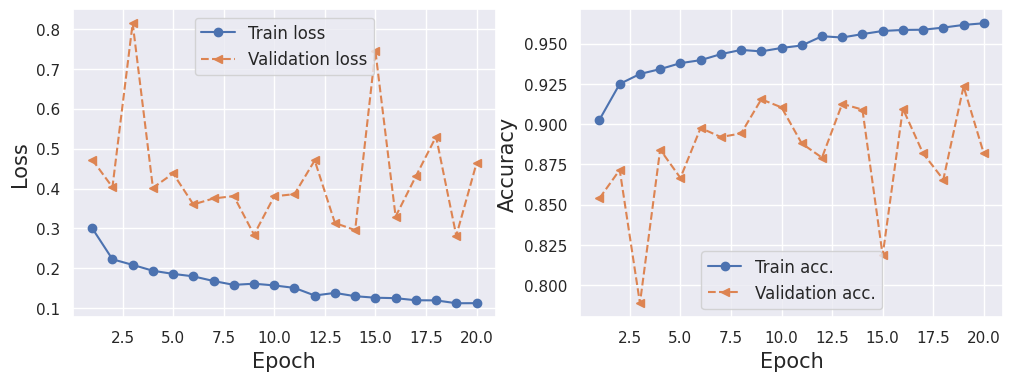

In [140]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [141]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 5s 16ms/step - loss: 0.5311 - accuracy: 0.8740

Test Acc. 87.40%


In [142]:
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(x_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 5s 13ms/step
[3 8 8 ... 5 1 7]


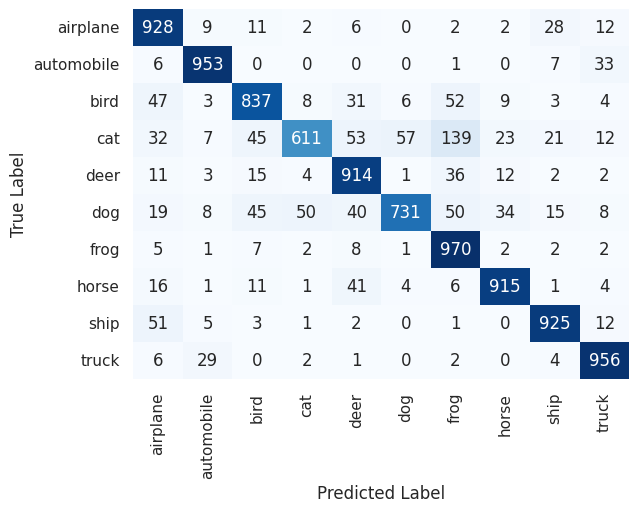

In [143]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [144]:
# Define the animal and non-animal classes
animal_indices = [2, 3, 4, 5, 6, 7]  # Indices of animal classes in the confusion matrix
non_animal_indices = [0, 1, 8, 9]  # Indices of non-animal classes in the confusion matrix

# Extract animal and non-animal confusion matrices
animal_confusion_matrix = tf.gather(confusion_matrix, indices=animal_indices, axis=0)
animal_confusion_matrix = tf.gather(animal_confusion_matrix, indices=animal_indices, axis=1)

non_animal_confusion_matrix = tf.gather(confusion_matrix, indices=non_animal_indices, axis=0)
non_animal_confusion_matrix = tf.gather(non_animal_confusion_matrix, indices=non_animal_indices, axis=1)

# Convert the confusion matrices to NumPy arrays
animal_confusion_matrix_np = animal_confusion_matrix.numpy()
non_animal_confusion_matrix_np = non_animal_confusion_matrix.numpy()

# Calculate true positives and false positives for animal and non-animal classes
animal_true_positives = np.diag(animal_confusion_matrix_np)
animal_false_positives = np.sum(animal_confusion_matrix_np, axis=0) - animal_true_positives

non_animal_true_positives = np.diag(non_animal_confusion_matrix_np)
non_animal_false_positives = np.sum(non_animal_confusion_matrix_np, axis=0) - non_animal_true_positives

# Calculate precision for animal and non-animal classes
animal_precision = np.sum(animal_true_positives) / (np.sum(animal_true_positives) + np.sum(animal_false_positives))
non_animal_precision = np.sum(non_animal_true_positives) / (np.sum(non_animal_true_positives) + np.sum(non_animal_false_positives))

print("Animal Precision:", animal_precision)
print("Non-Animal Precision:", non_animal_precision)

Animal Precision: 0.8625888060994629
Non-Animal Precision: 0.9490413723511605
